## 统计TM500 Ticket信息

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

import warnings
warnings.filterwarnings('ignore')

# TM500 weekly report路径
report_path = r"D:\TM500\Report\2017" 

try: 
    os.chdir(report_path)
except:
    print("The folder does not exist!")

In [2]:
# 获取report文件列表
def get_report_list():
    report_list = glob.glob("./*2017_W*.xlsx")
    if report_list is None:
        print("No files existed!")
    return report_list

# 分别获取open ticket和close ticket数据并以datafram格式返回
def get_report_data(file):
    report_data = pd.read_excel(file, sheetname=0)
    report_data.dropna(axis=0, how='all', inplace=True)
    report_data.dropna(axis=1, how='all', inplace=True)
    report_data.reset_index(inplace=True, drop=True)  # 重置索引并重新对索引排序
    index = report_data.index[report_data['Priority']=='Tickets closed in this week'] # 找出open ticket和close ticket的分界线
    ticket_opened_data = report_data.iloc[:index.tolist()[0],:]
    ticket_closed_data = report_data.iloc[index.tolist()[0]+1:,:] 
    
    week = re.search(r'.*(W\d+).*', file).group(1)
    
    return week, ticket_opened_data, ticket_closed_data

# 返回所有report中数据（datafram格式）列表
def get_report_list_data(report_list):
    ticket_opened_data_list = []
    ticket_closed_data_list = []    
    week_list = []
    
    for report in report_list:
        week, ticket_opened_data, ticket_closed_data = get_report_data(report)
        week_list.append(week)
        ticket_opened_data_list.append(ticket_opened_data)
        ticket_closed_data_list.append(ticket_closed_data)
         
    return week_list, ticket_opened_data_list, ticket_closed_data_list

# 纠正和统一'Action On'行中的一些拼写
def clean_up_data(data):
    data['Action On'] = data['Action On'].apply(lambda x: x.lower())
#     print(data.groupby('Action On').size())
    data['Action On'].replace('license transfer', 'License Issue', inplace=True)
    data['Action On'].replace('license', 'License Issue', inplace=True)
    data['Action On'].replace('licesne', 'License Issue', inplace=True)
    data['Action On'].replace('lincese', 'License Issue', inplace=True)
    data['Action On'].replace('no fault found', 'Not TM500 Issue', inplace=True)
    data['Action On'].replace('no fualt found', 'Not TM500 Issue', inplace=True)
    data['Action On'].replace('nokia', 'Not TM500 Issue', inplace=True)
    data['Action On'].replace('nok', 'Not TM500 Issue', inplace=True)
    data['Action On'].replace('enb', 'Not TM500 Issue', inplace=True)
    data['Action On'].replace('configuration error', 'Not TM500 Issue', inplace=True)
    data['Action On'].replace('hw', 'HW Issue', inplace=True)
    data['Action On'].replace('hardware', 'HW Issue', inplace=True)
    data['Action On'].replace('sw', 'SW Issue', inplace=True)
    data['Action On'].replace('tm500', 'SW Issue', inplace=True)
    data['Action On'].replace('r&d', 'SW Issue', inplace=True)
    data['Action On'].replace('query', 'Query Issue', inplace=True)
    data['Action On'].replace('upgrade', 'Upgrade', inplace=True)
    data['Action On'].replace('script', 'Script Issue', inplace=True)
#     print(data.groupby('Action On').size())
    return data

def handle_report_list_data(report_list): 
    
    ticket_closed_num = []
    ticket_opened_num = []
    ticket_opened_cumsum = []
    
    week_list, ticket_opened_data_list, ticket_closed_data_list = get_report_list_data(report_list)
    ticket_opened_data_all = pd.concat(ticket_opened_data_list)
    ticket_closed_data_all = pd.concat(ticket_closed_data_list)
    ticket_closed_data_all = clean_up_data(ticket_closed_data_all)
        
    report_num = len(week_list)
    for i in range(report_num):
        ticket_closed_num.append(len(ticket_closed_data_list[i]))
        ticket_opened_num.append(len(ticket_opened_data_list[i]))
        # 当前所有Open的ticket的数目等于之前所有Close的ticket的数目加上当前星期新增Open的ticket的数目
        ticket_opened_cumsum.append(len(ticket_opened_data_list[i])+np.cumsum(ticket_closed_num)[i])  
    
    print('Total Opened Ticket Number:', ticket_opened_cumsum[report_num-1])
    print('Total Closed Ticket Number:', len(ticket_closed_data_all))
    
    # 按星期对ticket进行统计
    fig = plt.figure(1,(22,10))
    ax1 = fig.add_subplot(111)
    # bottom参数用于绘制堆叠柱状图
    ax1.bar(week_list, ticket_closed_num, bottom=ticket_opened_num, color='#BCEE68', label='Closed Ticket Number In Week',)
    ax1.bar(week_list, ticket_opened_num, color='#FF83FA', label='Opened Ticket Number In Week')
    ax1.set_xlim(-1,report_num) # 设置x轴第一个tick到y轴之间距离
    ax1.set_ylim(0, np.max(ticket_closed_num)+np.max(ticket_opened_num)+5)
    ax1.set_xlabel('Week', fontsize=12)
    ax1.set_ylabel('Opened/Closed Ticket Number In Week', fontsize=12)
    ax1.legend(loc=2, fontsize=12)
    ax1.set_title('TM500 Weekly Opened/Closed Ticket Number Stat(2017)', fontsize=15)  
    ax1.yaxis.set_tick_params(labelsize=12) #设置tick label文字大小
    ax2 = ax1.twinx()
    ax2.plot(week_list, np.cumsum(ticket_closed_num), 'D-', markeredgecolor='g', markerfacecolor='w', lw=2.0, label='Total Closed Ticket Number')
    ax2.plot(week_list, ticket_opened_cumsum, 's-', markeredgecolor='r', markerfacecolor='w', lw=2.0, label='Total Opened Ticket Number')
    ax2.set_ylim(0, ticket_opened_cumsum[report_num-1]+100) #
    ax2.set_ylabel('Total Opened/Closed Ticket Number', fontsize=12)
    ax2.legend(loc=1, fontsize=12)
    ax2.yaxis.set_tick_params(labelsize=12) #设置tick label文字大小

#     # 设置tick和tick label之间的距离 
#     ax1.tick_params(direction='out', pad=15)

    
    plt.show()  
    
    # 对总ticket进行分类统计  
    fig = plt.figure(1,(16,8))
    ax1 = fig.add_subplot(121)
    color1 = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
    label1 = ['Priority-4', 'Priority-3', 'Priority-2', 'Priority-1\n(High Priority)' ]
    labeldistance1 = 1.05
    explode1 = (0, 0, 0, 0.05)
    patches1, texts1, autotexts1 = ax1.pie(ticket_closed_data_all['Priority'].value_counts(), labels=label1, 
                                           colors=color1, explode=explode1, labeldistance=labeldistance1,
                                           autopct='%1.2f%%')
    for t in texts1:
        t.set_size(12)
    for t in autotexts1:
        t.set_size(12)
#     ax1.set_title('TM500 Ticket Priority Distribution', weight='bold', size=12, position=(0.5, 0.96)) 
    # Position是title在这个ax中的位置的比例，比如0.5表示X轴方向正中间位置
    ax1.set_title('TM500 Ticket Priority Distribution', fontsize=15, position=(0.5, 0.96))
    ax2 = fig.add_subplot(122)
    color2 = ['#99CC33', '#FF9900', '#FFCC00', '#0099CC', '#FFFF66', '#CCCC33', '#FF6600']
    label2 = ['Not TM500 Issue', 'Query', 'License Issue', 'HW Issue', 'SW Issue', 'Script Issue', 'Upgrade']
    labeldistance2 = 1.05 
#   ax2 = ticket_closed_data_all['Action On'].value_counts().plot(kind='pie', colors=color2, autopct='%1.2f%%') #保留是为了检查label顺序和统计数据顺序是否一致
    patches2, texts2, autotexts2 = ax2.pie(ticket_closed_data_all['Action On'].value_counts(), labels=label2,
                                           colors=color2, labeldistance=labeldistance2,
                                           autopct='%1.2f%%')
    # 调整label文字和百分比文字的大小
    for t in texts2:
        t.set_size(12)
    for t in autotexts2:
        t.set_size(12)    
    ax2.set_title('TM500 Ticket Category Summary', fontsize=15, position=(0.5, 0.96))
    
    fig.tight_layout()
    plt.show()

Total Opened Ticket Number: 475
Total Closed Ticket Number: 469


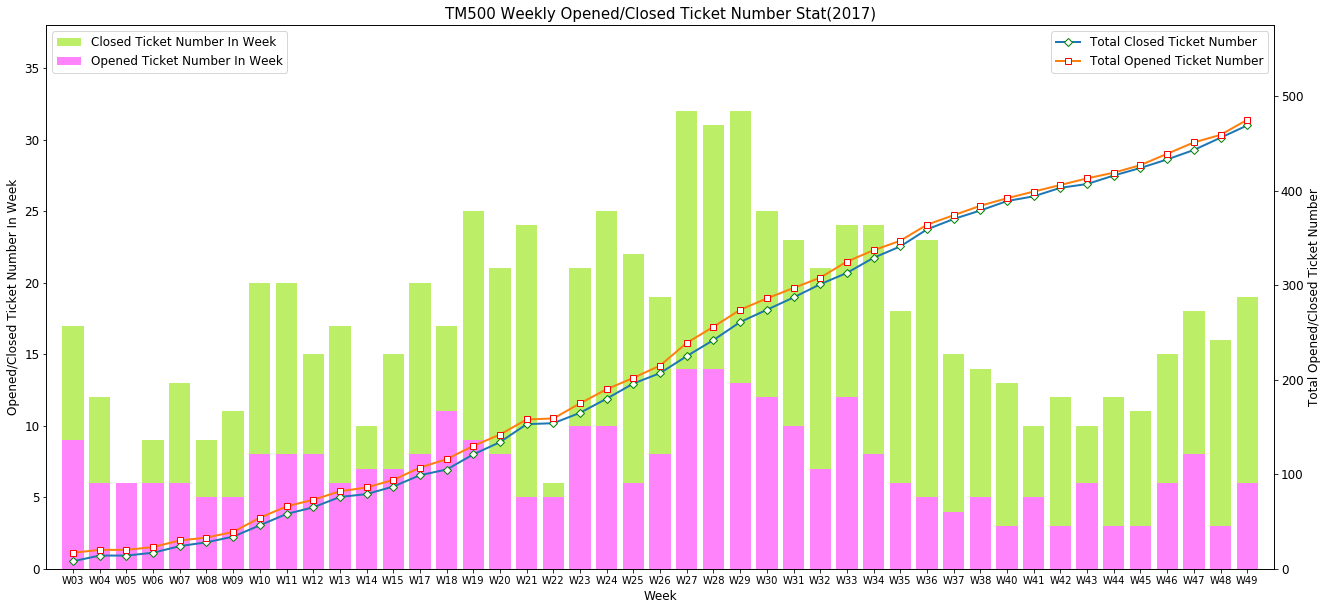

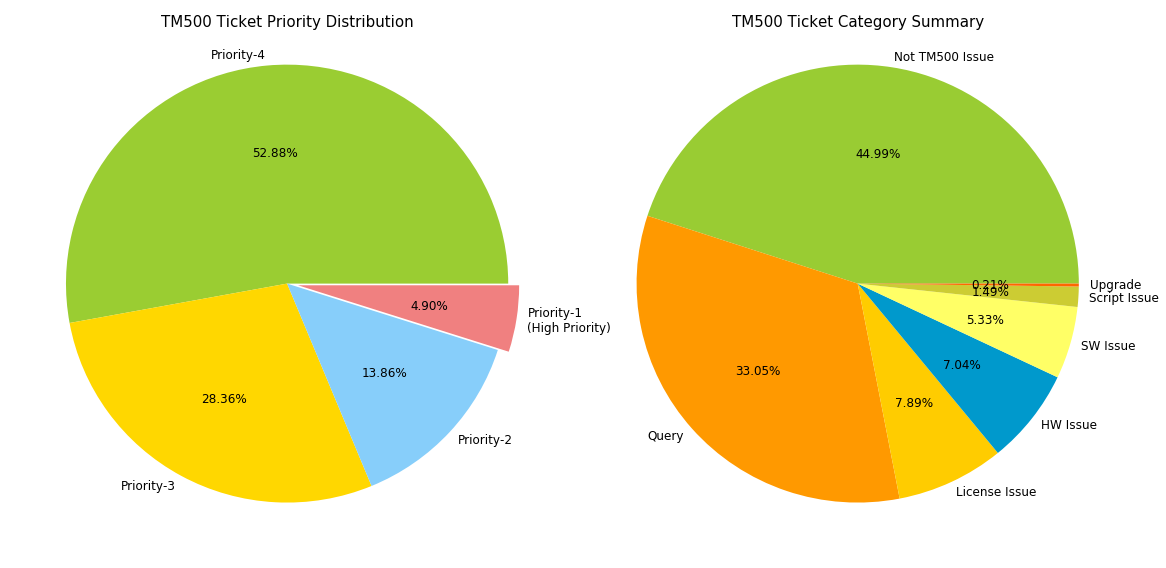

In [3]:
report_list = get_report_list()
handle_report_list_data(report_list)